In [1]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

import simulator


[get_brir] loaded kemar_hrtfs (Gardner & Martin, 1994): (368, 128, 2)
[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [3.962346663143529, 2.7522961568046957, 2.0], room_dim: [5, 4, 2]
[get_brir] time elapsed: 26.130730628967285 seconds


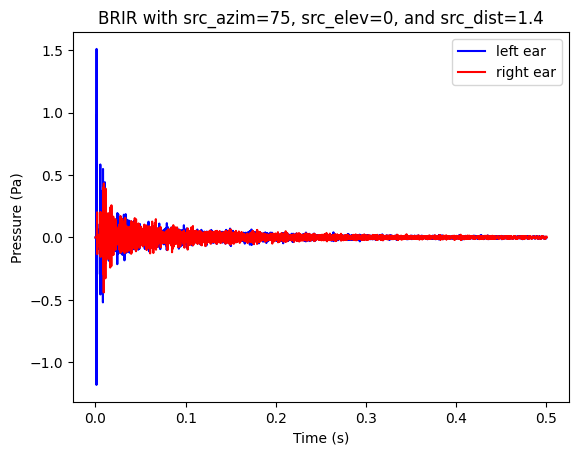

In [5]:
"""
Generate binaural room impulse response with specified parameters
"""
room_materials = [1, 1, 1, 1, 15, 16]
room_dim_xyz = [5, 4, 2]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = 0
src_azim = 75
src_elev = 0
src_dist = 1.4

c = 344.5
buffer = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_highpass = True
use_jitter = False
use_log_distance = False
hrtf_locs = None
hrtf_firs = None
incorporate_lead_zeros = False

brir = simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    dur=dur,
    use_jitter=use_jitter,
    use_hrtf_symmetry=use_hrtf_symmetry,
    incorporate_lead_zeros=incorporate_lead_zeros,
)

fig, ax = plt.subplots()
t = np.arange(0, brir.shape[0]) / sr
ax.plot(t, brir[:, 0], color="b", label="left ear")
ax.plot(t, brir[:, 1], color="r", label="right ear")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Pa)")
ax.set_title(f"BRIR with {src_azim=}, {src_elev=}, and {src_dist=}")
plt.show()


In [6]:
"""
Example single-channel audio waveform to be spatialized
"""
t = np.arange(0, 2, 1 / sr)
y = np.random.randn(*t.shape)
y = (np.sin(2 * np.pi * 2 * t) > 0) * y

ipd.display(ipd.Audio(rate=sr, data=y))


In [7]:
"""
Spatialize the example waveform by convolving with the binaural room impulse response
"""

def spatialize_sound(y, brir):
    """
    This takes a left-aligned BRIR and convolves it with a left-padded signal
    (using "valid" padding) to produce the same output as "same" padding with
    a center-aligned BRIR. It is faster to pad the signal than it is to pad
    the BRIR.

    Args
    ----
    y (np.ndarray): monoaural waveform with shape [timesteps]
    brir (np.ndarray): binaural room impulse response with shape [timesteps, 2]

    Returns
    -------
    y_spatialized (np.ndarray): binaural waveform with shape [timesteps, 2]
    """
    y_padded = np.pad(y, (brir.shape[0] - 1, 0))
    y_spatialized = scipy.signal.oaconvolve(
        y_padded[:, None],
        brir,
        mode="valid",
        axes=0,
    )
    return y_spatialized


y_spatialized = spatialize_sound(y, brir)
ipd.display(ipd.Audio(rate=sr, data=y_spatialized.T))
